# SOFR-Based Vasicek Short Rate Model & Monte Carlo Forecast

**Project overview**

This notebook calibrates a **Vasicek short-rate model** to historical SOFR (Secured Overnight Financing Rate) data and uses it to:

- Estimate the mean-reversion speed, long-run mean, and volatility of the short rate.
- Simulate future SOFR paths via Euler–Maruyama.
- Price zero-coupon bonds both **analytically** and via **Monte Carlo**.
- Build a simple **coupon-bond pricer** as a portfolio of zero-coupon bonds.

This implementation is based on **Chapter 17: Short Rates and Bond Pricing** from *Notes on Stochastic Finance* by Nicolas Privault.

Throughout, we use the Vasicek SDE in the canonical form

$$
dr_t = a(b - r_t)\,dt + \sigma\,dW_t,
$$

where $a>0$ is the **mean-reversion speed** and $b$ is the **long-run mean level** of the short rate.

**Workflow**

1. **Data loading** – Read SOFR history from `data/data.xlsx` and convert rates from percent to decimals.  
2. **Calibration** – Estimate $(a, b, \sigma)$ by linear regression on discretized daily changes.  
3. **Monte Carlo simulation** – Generate forward short-rate paths under the calibrated Vasicek model.  
4. **Zero-coupon pricing** – Compare Monte Carlo prices with the closed-form Vasicek solution.  
5. **Coupon bond pricing** – Price a fixed-rate coupon bond as a sum of zero-coupon bonds.

In [1]:
import sys
from pathlib import Path

# Add project root to path for imports
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.vasicek import VasicekModel

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12

## 1. Data Loading & Preprocessing

We load the historical SOFR data from `data/data.xlsx`. The dataset includes:

- **Effective Date**
- **Rate (%)**

Steps:

1. Parse the date column into `datetime` and sort in chronological order.  
2. Rename the columns to `date` and `rate_pct` for clarity.  
3. Convert the percentage rate into a decimal short rate

$$
\text{rate} = \frac{\text{rate\_pct}}{100},
$$

so, for example, $4.5\%$ becomes $0.045$.

The cleaned DataFrame `df_sofr` is the basis for calibration and simulation.


In [2]:
# Path relative to project root (notebook is in notebooks/)
sofr_path = project_root / "data" / "data.xlsx"
df_sofr_raw = pd.read_excel(sofr_path)

# Rename and select relevant columns
df_sofr = df_sofr_raw.rename(
    columns={
        "Effective Date": "date",
        "Rate (%)": "rate_pct"
    }
)[["date", "rate_pct"]].copy()

# Convert date to datetime and sort
df_sofr["date"] = pd.to_datetime(df_sofr["date"])
df_sofr = df_sofr.sort_values("date").reset_index(drop=True)

# Convert percentage rate to decimal (e.g., 4.5% -> 0.045)
df_sofr["rate"] = df_sofr["rate_pct"] / 100.0

print(f"Data Loaded: {len(df_sofr)} rows")
df_sofr.head()

Data Loaded: 177 rows


C:\Users\aarus\AppData\Roaming\Python\Python312\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,date,rate_pct,rate
0,2024-12-31,4.49,0.0449
1,2025-01-02,4.40,0.0440
2,2025-01-03,4.31,0.0431
3,2025-01-06,4.27,0.0427
4,2025-01-07,4.27,0.0427


## 2. Historical Rate Analysis

We first visualize the historical SOFR time series. This gives a sense of:

- Typical levels and volatility.
- Regimes (e.g., near-zero vs. high-rate periods).
- The **current short rate** $r_0$, taken as the last observed value.

This $r_0$ will be the starting point for our Vasicek simulations and bond pricing.

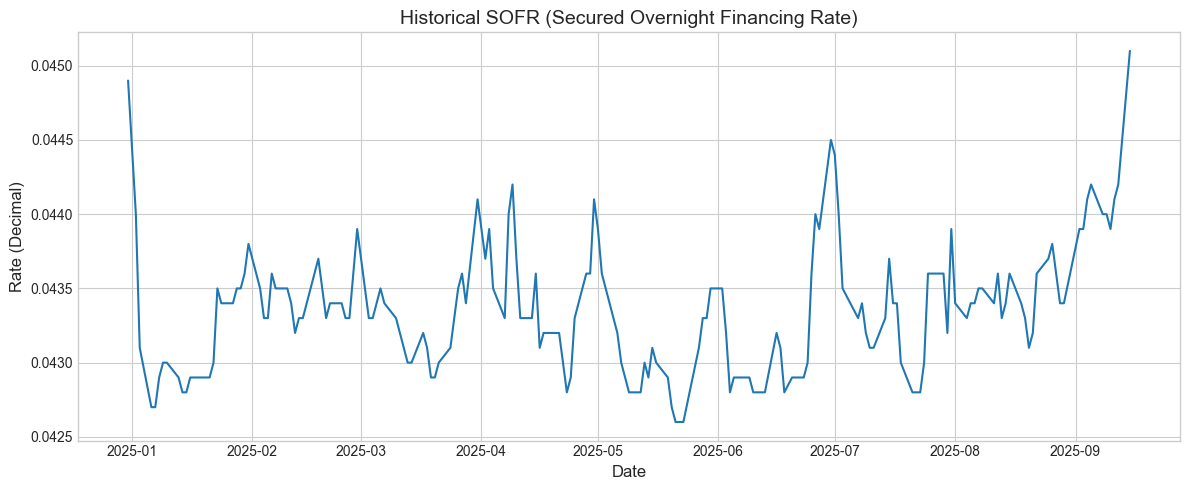

In [3]:
plt.figure(figsize=(12, 5))
plt.plot(df_sofr["date"], df_sofr["rate"], lw=1.5, color='#1f77b4')
plt.title("Historical SOFR (Secured Overnight Financing Rate)")
plt.xlabel("Date")
plt.ylabel("Rate (Decimal)")
plt.tight_layout()
plt.show()

## 3. Calibrate Vasicek Model Parameters

To estimate $a$, $b$, and $\sigma$, we treat the daily data as an Euler discretization of

$$
dr_t = a(b - r_t)\,dt + \sigma\,dW_t.
$$

With step size $\Delta t$ (one business day, $\Delta t = 1/252$), the Euler scheme is

$$
r_{t+\Delta t}
= r_t + a(b - r_t)\,\Delta t + \sigma\sqrt{\Delta t}\,Z_t,
\qquad Z_t \sim \mathcal N(0,1),
$$

which we rewrite as a linear regression:

$$
r_{t+\Delta t}
= \underbrace{(1 - a\Delta t)}_{\text{slope}}\,r_t
+ \underbrace{(ab\Delta t)}_{\text{intercept}}
+ \varepsilon_t.
$$

We then:

1. Regress $r_{t+\Delta t}$ on $r_t$ to obtain the slope and intercept.  
2. Recover parameters via
   $$
   a = \frac{1 - \text{slope}}{\Delta t},
   \qquad
   b = \frac{\text{intercept}}{a\Delta t}.
   $$
3. Estimate volatility from the regression residuals:
   $$
   \sigma = \frac{\operatorname{std}(\varepsilon_t)}{\sqrt{\Delta t}}.
   $$

> **Note on notation**  
> In Privault's text the Vasicek model is written as
> $$
> dr_t = \big(a_{\text{text}} - b_{\text{text}} r_t\big)\,dt + \sigma\,dB_t,
> $$
> whose long-run mean is $a_{\text{text}}/b_{\text{text}}$.  
> Our $(a, b)$ correspond to $(b_{\text{text}}, a_{\text{text}}/b_{\text{text}})$: in this notebook, **$a$ is the mean-reversion speed and $b$ is the long-run mean level**.


In [4]:
# Initialize model with placeholder parameters and calibrate from data
model = VasicekModel(a=1.0, b=0.05, sigma=0.01)
model.calibrate(df_sofr["rate"], dt=1/252)

# Store calibrated parameters for later use
r0 = model.current_rate
a_hat = model.a
b_hat = model.b
sigma_hat = model.sigma

print("--- Calibrated Vasicek Parameters ---")
print(f"Mean Reversion Speed (a):  {a_hat:.4f}")
print(f"Long-Term Mean Level (b):  {b_hat:.4f} ({b_hat:.2%})")
print(f"Volatility (sigma):        {sigma_hat:.4f}")
print(f"\n{model}")

--- Calibrated Vasicek Parameters ---
Mean Reversion Speed (a):  50.2844
Long-Term Mean Level (b):  0.0433 (4.33%)
Volatility (sigma):        0.0041

VasicekModel(a=50.284351, b=0.043349, sigma=0.004065, current_rate=0.045100)


## 4. Monte Carlo Simulation

Using the calibrated parameters $(a, b, \sigma)$, we simulate future SOFR paths under the Vasicek dynamics:

$$
r_{t+\Delta t}
= r_t + a(b - r_t)\,\Delta t + \sigma \sqrt{\Delta t}\,Z_t,
\qquad Z_t \sim \mathcal N(0,1).
$$

Configuration:

- **Horizon:** $T = 1$ year 
- **Time steps:** 252 (business days)  
- **Number of paths:** 1,000  
- **Initial short rate:** $r_0$ (last observed SOFR)

We seed the random number generator for reproducibility and later summarize the Monte Carlo distribution with:

- The **mean path** across simulations.  
- A **fan chart** showing approximate $95\%$ bands around the mean.  
- The **long-run mean level** $b$ as a horizontal reference line.


In [5]:
# Simulation Parameters
T_future = 1.0
n_steps = 252
n_sims = 1000
dt = T_future / n_steps

# Simulate paths using the calibrated model
paths = model.simulate(n_paths=n_sims, n_steps=n_steps, dt=dt, seed=42)

# Transpose for compatibility with existing plotting code (shape: n_steps+1, n_sims)
rates_future = paths.T

# Time axis for plotting
t_future = np.linspace(0, T_future, n_steps + 1)
last_date = df_sofr["date"].iloc[-1]
dates_future = [last_date + pd.Timedelta(days=x*365/252) for x in range(n_steps + 1)]

print(f"Simulated {n_sims} paths starting from r0 = {r0:.2%}")

Simulated 1000 paths starting from r0 = 4.51%


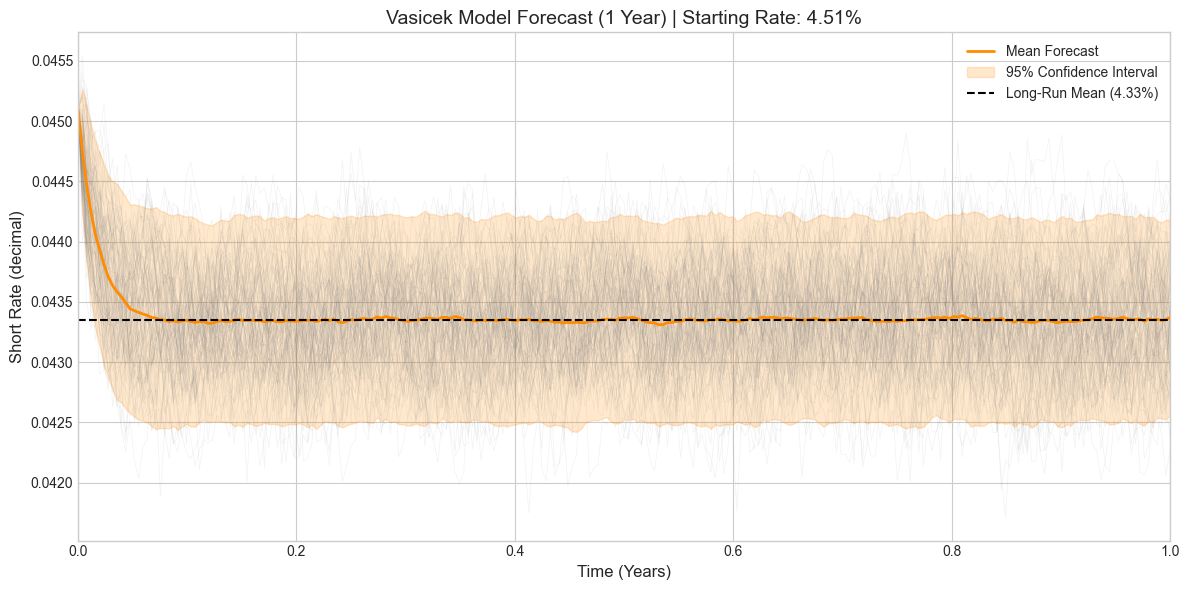

In [6]:
# Calculate statistics for the fan chart
mean_path = rates_future.mean(axis=1)
std_path = rates_future.std(axis=1)
upper_bound = mean_path + 2 * std_path
lower_bound = mean_path - 2 * std_path

# Plotting
plt.figure(figsize=(12, 6))

# Plot a subset of individual paths (first 100)
plt.plot(t_future, rates_future[:, :100], color="grey", alpha=0.1, lw=0.5)

# Plot Mean and Confidence Interval
plt.plot(t_future, mean_path, color="darkorange", lw=2, label="Mean Forecast")
plt.fill_between(
    t_future,
    lower_bound,
    upper_bound,
    color="darkorange",
    alpha=0.2,
    label="95% Confidence Interval",
)

# Plot Long-Run Mean
plt.axhline(
    y=b_hat, color="black", linestyle="--", label=f"Long-Run Mean ({b_hat:.2%})"
)

plt.title(f"Vasicek Model Forecast (1 Year) | Starting Rate: {r0:.2%}")
plt.xlabel("Time (Years)")
plt.ylabel("Short Rate (decimal)")
plt.legend(loc='upper right')
plt.xlim(0, T_future)
plt.tight_layout()
plt.show()

## 5. Zero-Coupon Bond Pricing

We price a zero-coupon bond paying $1$ at time $T$. Under a risk-neutral measure,
the price is the expected discounted payoff:

$$
P(0, T)
= \mathbb{E}^{\mathbb{Q}}\!\left[
\exp\left( - \int_0^T r_u\,du \right)
\right].
$$

### 5.1 Closed-Form Vasicek Solution

In the Vasicek model, the zero-coupon bond price has a closed form:

$$
P(0, T) = A(T)\, e^{-B(T)\, r_0},
$$

with

$$
B(T) = \frac{1 - e^{-aT}}{a},
$$

and

$$
A(T)
= \exp\left\{
\left(
b - \frac{\sigma^2}{2a^2}
\right)\big(B(T) - T\big)
- \frac{\sigma^2}{4a} B(T)^2
\right\}.
$$

Here $r_0$ is the current short rate and $(a,b,\sigma)$ are the calibrated Vasicek parameters.

### 5.2 Monte Carlo Estimate

We can also estimate $P(0,T)$ from the simulated paths. For a given path $j$,
we approximate the time integral by a Riemann sum:

$$
\int_0^T r_u^{(j)} \, du
\;\approx\;
\sum_{k=1}^{n} r_{k}^{(j)} \,\Delta t,
$$

where $r_k^{(j)}$ is the simulated short rate on that path at step $k$.
The pathwise discount factor is then

$$
D^{(j)}(0,T)
= \exp\left(
- \sum_{k=1}^{n} r_{k}^{(j)} \,\Delta t
\right).
$$

The Monte Carlo estimator of the bond price is

$$
P_{\text{MC}}(0, T)
\approx
\frac{1}{M} \sum_{j=1}^{M} D^{(j)}(0,T),
$$

which we compare against the analytical formula.


In [7]:
# Calculate Analytical Price for T=1 year using the model's price_bond method
price_analytical = model.price_bond(r_t=r0, T=T_future)
print(f"Analytical Price (T={T_future:.1f}): ${price_analytical:.7f}")

Analytical Price (T=1.0): $0.9575439


### 5.2 Monte Carlo Estimate
We approximate the integral $\int_0^T r_u\,du$ by summing the discrete rates along each path.

In [8]:
# 1. Approximate integral for each path: Sum over t=0..n_steps-1
integral_r = np.sum(rates_future[:-1, :], axis=0) * dt

# 2. Compute Discount Factors: exp(-integral)
discount_factors = np.exp(-integral_r)

# 3. Average Discount Factor = Bond Price
price_mc = np.mean(discount_factors)
mc_std_error = np.std(discount_factors) / np.sqrt(n_sims)

print(f"Monte Carlo Price (T={T_future:.1f}):   ${price_mc:.7f}")
print(f"Standard Error:                 ${mc_std_error:.5f}")
print(f"Difference (MC - Analytical):   ${price_mc - price_analytical:.5f}")

Monte Carlo Price (T=1.0):   $0.9575442
Standard Error:                 $0.00000
Difference (MC - Analytical):   $0.00000


## 6. Yield Curve Verification

To test the implementation across the term structure, we:

1. Compute analytic Vasicek zero-coupon prices $P(0,T)$ for maturities $T = 1, 2, \dots, 10$ years.  
2. For each maturity $T$, run a separate Monte Carlo simulation and compute the corresponding $P_{\text{MC}}(0,T)$.  
3. Plot the analytical curve and the Monte Carlo estimates on the same chart.

In a well-implemented model, the Monte Carlo points should lie close to the analytical curve, with small deviations attributable to simulation noise rather than model or coding errors.


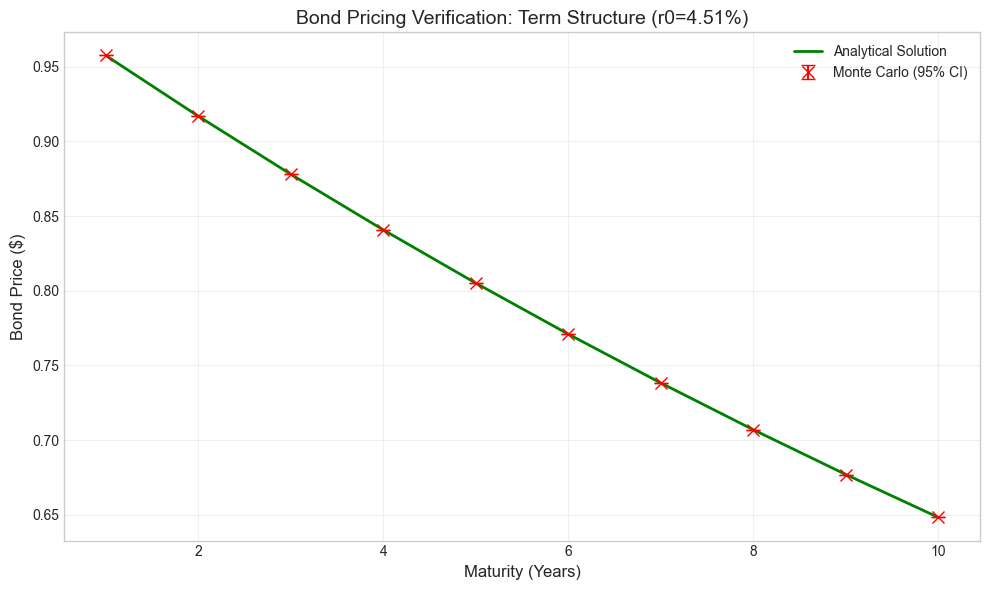

In [9]:
def monte_carlo_zcb_price(model: VasicekModel, T: float, n_sims: int = 10_000, seed: int = None):
    """
    Monte Carlo estimate of Vasicek zero-coupon bond price P(0, T).
    Returns (price, standard_error).
    """
    n_steps = int(T * 252)
    dt = T / n_steps
    
    # Simulate paths
    paths = model.simulate(n_paths=n_sims, n_steps=n_steps, dt=dt, seed=seed)
    
    # Approximate integral on each path (exclude final column)
    integral_r = np.sum(paths[:, :-1], axis=1) * dt
    
    # Compute discount factors with clipping to avoid overflow
    exponent = np.clip(-integral_r, -700, 700)
    discount_factors = np.exp(exponent)
    
    price = discount_factors.mean()
    std_error = discount_factors.std() / np.sqrt(n_sims)
    
    return price, std_error


maturities = np.arange(1, 11)
mc_results = [monte_carlo_zcb_price(model, T, seed=42) for T in maturities]
prices_mc = [res[0] for res in mc_results]
errors_mc = [res[1] for res in mc_results]

# Analytical prices using model.price_bond
prices_exact = [model.price_bond(r_t=r0, T=T) for T in maturities]

# Plot Comparison with Error Bars
plt.figure(figsize=(10, 6))
plt.plot(maturities, prices_exact, label='Analytical Solution', color='green', lw=2)
plt.errorbar(maturities, prices_mc, yerr=np.array(errors_mc)*1.96, fmt='x', color='red', 
             label='Monte Carlo (95% CI)', capsize=5, markersize=8, zorder=10)

plt.title(f"Bond Pricing Verification: Term Structure (r0={r0:.2%})")
plt.xlabel("Maturity (Years)")
plt.ylabel("Bond Price ($)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Coupon Bond Pricing

A fixed-rate coupon bond can be written as a portfolio of zero-coupon bonds.

- Coupons: level cash flows $C$ at times $t_1, t_2, \dots, t_n$.  
- Principal: face value $F$ at maturity $T = t_n$.

If $P(0,t)$ denotes the zero-coupon price for maturity $t$, then the coupon-bond price is

$$
P_{\text{coupon}}(0)
= \sum_{i=1}^{n} C\, P(0, t_i) + F\, P(0, T).
$$

In code, we:

1. Use the analytical Vasicek zero-coupon formula for each payment date $t_i$ and for the final maturity $T$.  
2. Sum the discounted coupons and the discounted principal.  
3. Illustrate the result for a 5-year, $4.5\%$ semi-annual coupon bond with face value $F = 100$.


In [10]:
def price_coupon_bond(model: VasicekModel, r0: float, T: float, coupon_rate: float, 
                      freq: int = 2, face_value: float = 100.0) -> float:
    """
    Prices a coupon bond as a sum of zero-coupon bonds under Vasicek.
    """
    dt_coupon = 1.0 / freq
    n_periods = int(round(T * freq))
    times = np.arange(1, n_periods + 1) * dt_coupon

    c_payment = (coupon_rate * face_value) / freq

    pv_coupons = sum(c_payment * model.price_bond(r_t=r0, T=t) for t in times)
    pv_principal = face_value * model.price_bond(r_t=r0, T=T)

    return pv_coupons + pv_principal


# Example: 5-Year Bond, 4.5% Coupon, Semi-Annual
coupon_rate = 0.045
T_bond = 5.0
price = price_coupon_bond(model, r0, T_bond, coupon_rate)

print(f"--- Coupon Bond Pricing ---")
print(f"Maturity:      {T_bond} Years")
print(f"Coupon Rate:   {coupon_rate:.2%}")
print(f"Fair Value:    ${price:.2f}")
print(f"Par Value:     $100.00")

--- Coupon Bond Pricing ---
Maturity:      5.0 Years
Coupon Rate:   4.50%
Fair Value:    $100.52
Par Value:     $100.00
